# 1. 神经网络结构设计与调优
在人工构造的MNIST数据集的子集上进行训练/测试，要求：

（1）参考课件中给出的代码，实现以下两种不同的网络结构（要求用numpy手动实现前向传播和反向传播等过程）：
- 2层前馈网络，以sigmoid或tanh作为激活函数（选择效果较好的一个即可），隐含层维度自定
- 3层前馈网络，以relu作为激活函数，隐含层维度自定

（2）两个网络在测试集上分类准确率均$\ge$90%

（3）画出训练过程中训练集上loss和训练集上accuracy的变化曲线

（4）参考课件中给出的代码，可视化神经网络在测试集上的预测结果，要求标出true positive(TP)以及TN/FP/FN，并计算accuracy

（5）公平起见，只能用给出的MNIST子集，不能自行取其他子集


本次作业涉及到的激活函数的定义及其导函数：
- $sigmoid(x)=1/(1+e^{-x})$, 导函数$sigmoid(x)(1-sigmoid(x))$
- $tanh(x)=(e^x-e^{-x})/(e^x+e^{-x})$，导函数$1-tanh^2(x)$
- $relu(x)=max(0,x)$，导函数$f(x)=\begin{cases}1, x>0 \\ 0, x\le0\end{cases}$

调优的角度，包括但不限于：
- batch size大小
- loss function（MSE，交叉熵……）
- 优化器的参数（学习率，学习率调整策略，优化器类型……）
- iteration数量

其他：
- 网络权重初始化策略
- 数据预处理

In [1]:
# 读取训练和测试数据
# 本次作业为加快训练速度，只取1000个样本作为训练集，200个样本作为测试集
# 每个样本原本是28*28的图片，reshape成784维向量输入神经网络
# 只取（形状比较相近的）数字8和数字9两个类，做二分类，并将数字8的label重新标为0，数字9的label重新标为1
# 两个类的训练样本数不均衡（1:3）
# 本部分代码不可修改

import numpy as np
f = np.load('mnist.npz') 
x_train, y_train = f['x_train'], f['y_train'] 
x_test, y_test = f['x_test'], f['y_test'] 

def get_small_data(x_data, y_data, num1, num2):
    cnt1, cnt2, final_x, final_y = 0, 0, [], []
    for i in range(x_data.shape[0]):
        x = x_data[i, :].reshape(-1).tolist()
        y = y_data[i]
        if y == 8 and cnt1 < num1:
            final_x.append(x)
            final_y.append(0)
            cnt1 += 1
        elif y == 9 and cnt2 < num2:
            final_x.append(x)
            final_y.append(1)
            cnt2 += 1
    return np.array(final_x), np.array(final_y)

x_train, y_train = get_small_data(x_train, y_train, num1=250, num2=750)
x_test, y_test = get_small_data(x_test, y_test, num1=100, num2=100)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1000, 784)
(1000,)
(200, 784)
(200,)


In [2]:
#Sigmoid function
def sigmoid(x):
    a = np.exp(-x)
    return 1.0 / (1.0 + a)

def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

#Relu function
def relu(x):
    res = x.copy()
    res[x<=0]=0
    return res

def drelu(x):
    res = x.copy()
    res[x<=0]=0
    res[x>0]=1
    return res

#MSE loss
def loss_fn(y_pred,y):
    res = 0
    for i,j in enumerate(y):
        res += (y[i]-y_pred[i])**2
    return np.log(res / len(y))



# 2层前馈网络

In [3]:
# 2层前馈网络，以sigmoid或tanh作为激活函数
# W为各层权重，X为输入的特征，Y为标签
def net1_forward(W1, W2, X, Y):
    global debug
    #result of 1st layer
    Z1 = np.dot(X,W1) #1000x784,784x128 => 1000x128
    A1 = sigmoid(Z1) #1000x128
    
    #result of 2nd layer
    Z2 = np.dot(A1,W2) #1000x128,128,1 => 1000x1
    A3 = sigmoid(Z2) #1000x1
    
    #反向梯度传播
    J_Z2_grad = -Y + A3 #1000x1
    J_W2_grad = np.dot(J_Z2_grad, A1) #1000x1, 1000x128 => 128x1
    
    A1_Z1_grad = dsigmoid(Z1)
    J_W1_grad = (np.dot((J_Z2_grad).reshape(-1,1), W2.reshape(-1,1).T)*A1_Z1_grad).T.dot(X).T
    
    gradient = (J_W1_grad, J_W2_grad)
    return A3, gradient

In [4]:
W1 = np.random.uniform(-1,1,size=(784,128))
W2 = np.random.uniform(-1,1,size=(128))
n = 1000
num_iter = 2000
learning_rate =.001
loss_vals, accuracies = [],[]
for i in range(num_iter):
    y_pred, (J_W1_grad, J_W2_grad) = net1_forward(W1,W2,x_train,y_train)
    W1 = W1 - learning_rate * J_W1_grad
    W2 = W2 - learning_rate * J_W2_grad
    
    #Compute loss and accuracy
    curr_loss = loss_fn(y_train,y_pred)
    loss_vals.append(curr_loss)
    acc = np.sum((y_pred>=.5) == y_train)/n
    accuracies.append(acc)
    if((i%250)==0):
        print(f"iteration {i}: log loss is {curr_loss:.2f}; accuracy is {acc}")


iteration 0: log loss is -1.39; accuracy is 0.75


<ipython-input-2-fe75b8e84edb>:3: RuntimeWarning: overflow encountered in exp
  a = np.exp(-x)


iteration 250: log loss is -4.18; accuracy is 0.981
iteration 500: log loss is -4.55; accuracy is 0.99
iteration 750: log loss is -4.80; accuracy is 0.991
iteration 1000: log loss is -5.01; accuracy is 0.993
iteration 1250: log loss is -5.20; accuracy is 0.995
iteration 1500: log loss is -5.36; accuracy is 0.996
iteration 1750: log loss is -5.50; accuracy is 0.998


In [5]:
# test
y_pred, (J_W1_grad, J_W2_grad) = net1_forward(W1,W2,x_test,y_test)
acc = np.sum((y_pred>=.5) == y_test)/200
print(f"test accuracy: {acc}")

test accuracy: 0.915


<ipython-input-2-fe75b8e84edb>:3: RuntimeWarning: overflow encountered in exp
  a = np.exp(-x)


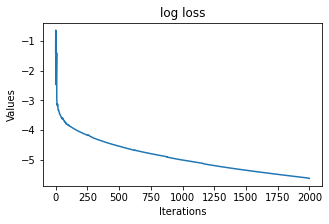

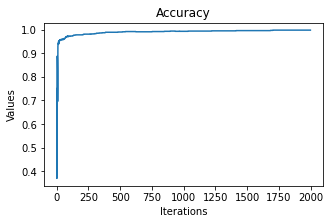

In [6]:
# 训练集的loss和accuracy
import matplotlib.pyplot as plt
f1 = plt.figure(1, figsize = (5,3))    
plt.plot(loss_vals)
plt.title('log loss')
plt.xlabel('Iterations')
plt.ylabel('Values')

f2 = plt.figure(2, figsize = (5,3)) 
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.show()

Accuracy = 0.915


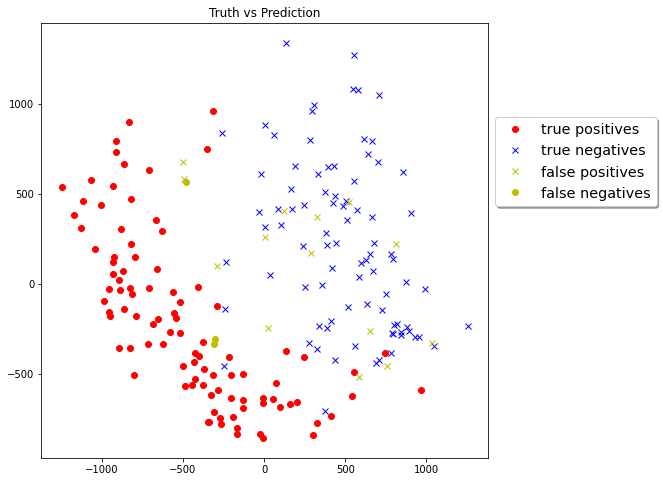

In [7]:
#模型预测结果可视化
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
pca_model.fit(x_test)
pca_2d = pca_model.transform(x_test)

pred1 = (y_pred>=.5)
pred0 = (y_pred<.5)

fig, ax = plt.subplots(figsize=(8,8))
# true predictions
ax.plot(pca_2d[pred1 & (y_test==1), 0], pca_2d[pred1 & (y_test==1), 1], 'ro', label='true positives')
ax.plot(pca_2d[pred0 & (y_test==0), 0], pca_2d[pred0 & (y_test==0), 1], 'bx', label='true negatives')
# false predictions
ax.plot(pca_2d[pred1 & (y_test==0), 0], pca_2d[pred1 & (y_test==0), 1], 'yx', label='false positives')
ax.plot(pca_2d[pred0 & (y_test==1), 0], pca_2d[pred0 & (y_test==1), 1], 'yo', label='false negatives')
ax.set(title='Truth vs Prediction')
ax.legend(bbox_to_anchor=(1,0.8),fancybox=True, shadow=True,fontsize='x-large')
accuracy = (len(pca_2d[pred1&(y_test)==1]) + len(pca_2d[pred0&(y_test==0)]))/len(pca_2d)
print(f"Accuracy = {accuracy}")

# 3层前馈网络

In [8]:
# 3层前馈网络，以relu作为激活函数
def net2_forward(W1, W2, W3, X, Y):
    #1st layer
    Z1 = np.dot(X,W1) #1000x784,784x128 => 1000x128
    A1 = relu(Z1) #1000x128
    #2nd layer
    Z2 = np.dot(A1,W2) #1000x128,128x64 => 1000x64
    A2 = relu(Z2) #1000x64
    #3rd layer
    Z3 = np.dot(A2,W3) #1000x64,64x1
    A3 = sigmoid(Z3) #1000x1
      
    #反向梯度传播
    J_Z3_grad = -Y + A3 #1000x1
    J_W3_grad = np.dot(J_Z3_grad, A2) #1000x1,1000x128 => 128x1
    
    A2_Z2_grad = drelu(Z2) #1000x64
    J_W2_grad = (np.dot((J_Z3_grad).reshape(-1,1), W3.reshape(-1,1).T)*A2_Z2_grad).T.dot(A1).T
    
    A1_Z1_grad = drelu(Z1) #1000x128
    J_W1_grad = ((np.dot((J_Z3_grad).reshape(-1,1), W3.reshape(-1,1).T)*A2_Z2_grad).dot(W2.T)*A1_Z1_grad).T.dot(X).T
    #1000x1, 1x64 => 1000x64 * 1000x64 => 1000x64, 64x128 => 1000x128 * 1000x128 => 128x1000, 1000x728 => 728x128
    return A3, (J_W1_grad, J_W2_grad, J_W3_grad)
    

In [24]:
W1 = np.random.uniform(-1,1,size=(784,256))
W2 = np.random.uniform(-1,1,size=(256,128))
W3 = np.random.uniform(-1,1,size=(128,))
n = 1000
num_iter = 3000
learning_rate =.000000001
loss_vals, accuracies = [],[]
for i in range(num_iter):
    y_pred, (J_W1_grad, J_W2_grad, J_W3_grad) = net2_forward(W1,W2,W3,x_train,y_train)
    W1 = W1 - learning_rate * J_W1_grad
    W2 = W2 - learning_rate * J_W2_grad
    W3 = W3 - learning_rate * J_W3_grad
    
    #Compute loss and accuracy
    curr_loss = loss_fn(y_train,y_pred)
    loss_vals.append(curr_loss)
    acc = np.sum((y_pred>=.5) == y_train)/n
    accuracies.append(acc)
    if((i%500)==0):
        print(f"iteration {i}: log loss is {curr_loss:.2f}; accuracy is {acc}")


<ipython-input-2-fe75b8e84edb>:3: RuntimeWarning: overflow encountered in exp
  a = np.exp(-x)


iteration 0: log loss is -0.30; accuracy is 0.256
iteration 500: log loss is -2.43; accuracy is 0.912
iteration 1000: log loss is -2.98; accuracy is 0.949
iteration 1500: log loss is -3.18; accuracy is 0.958
iteration 2000: log loss is -3.65; accuracy is 0.974
iteration 2500: log loss is -4.33; accuracy is 0.987


In [25]:
# test
y_pred, (J_W1_grad, J_W2_grad, J_W3_grad) = net2_forward(W1,W2,W3,x_test,y_test)
acc = np.sum((y_pred>=.5) == y_test)/200
print(f"test accuracy: {acc}")

test accuracy: 0.92


<ipython-input-2-fe75b8e84edb>:3: RuntimeWarning: overflow encountered in exp
  a = np.exp(-x)


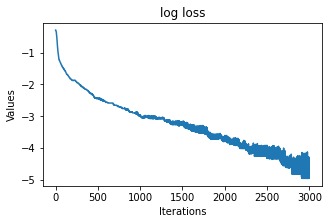

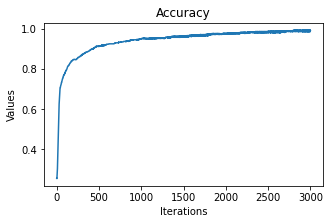

In [26]:
# 训练集的loss和accuracy
import matplotlib.pyplot as plt
f1 = plt.figure(1, figsize = (5,3))    
plt.plot(loss_vals)
plt.title('log loss')
plt.xlabel('Iterations')
plt.ylabel('Values')

f2 = plt.figure(2, figsize = (5,3)) 
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.show()

Accuracy = 0.92


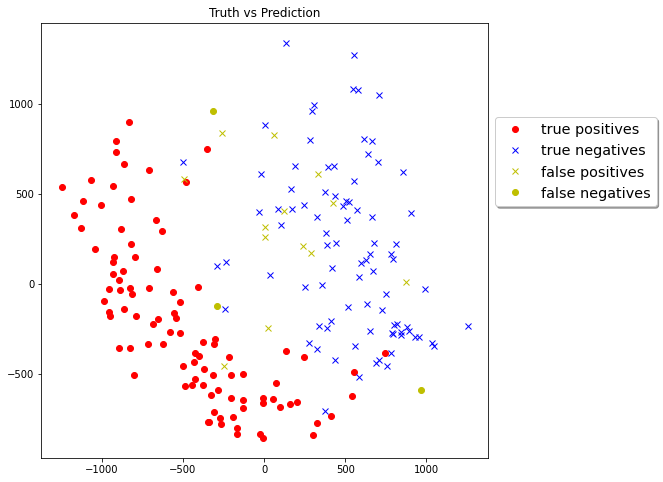

In [27]:
#模型预测结果可视化
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)
pca_model.fit(x_test)
pca_2d = pca_model.transform(x_test)

pred1 = (y_pred>=.5)
pred0 = (y_pred<.5)

fig, ax = plt.subplots(figsize=(8,8))
# true predictions
ax.plot(pca_2d[pred1 & (y_test==1), 0], pca_2d[pred1 & (y_test==1), 1], 'ro', label='true positives')
ax.plot(pca_2d[pred0 & (y_test==0), 0], pca_2d[pred0 & (y_test==0), 1], 'bx', label='true negatives')
# false predictions
ax.plot(pca_2d[pred1 & (y_test==0), 0], pca_2d[pred1 & (y_test==0), 1], 'yx', label='false positives')
ax.plot(pca_2d[pred0 & (y_test==1), 0], pca_2d[pred0 & (y_test==1), 1], 'yo', label='false negatives')
ax.set(title='Truth vs Prediction')
ax.legend(bbox_to_anchor=(1,0.8),fancybox=True, shadow=True,fontsize='x-large')
accuracy = (len(pca_2d[pred1&(y_test)==1]) + len(pca_2d[pred0&(y_test==0)]))/len(pca_2d)
print(f"Accuracy = {accuracy}")

# 2. PyTorch基础练习
请注意，本题要求全部基于pytorch实现，不能使用pytorch的.tolist()或者.numpy()等函数将tensor转换成list或者numpy array来处理

（1）首先，创建一个服从标准正态分布的$3\times 4$的tensor $A$，和一个服从标准正态分布的$2\times6$的tensor $B$

In [13]:
import torch
A = torch.randn(3,4,dtype=torch.double,requires_grad=True)
B = torch.randn(2,6,dtype=torch.double,requires_grad=True)
A,B

(tensor([[ 0.4527,  1.1473,  0.7546, -0.0943],
         [-1.1913, -0.6058,  1.4282,  2.3584],
         [-1.2204,  1.6657,  1.4779,  1.1672]], dtype=torch.float64,
        requires_grad=True),
 tensor([[ 0.5709, -1.3881,  0.2275, -0.6966, -0.1514,  1.3944],
         [ 0.1467,  2.4346,  1.5918, -0.5586,  0.1278, -0.3842]],
        dtype=torch.float64, requires_grad=True))

（2）使用view操作将$B$的形状也转换成$3\times 4$，计算$A+B$和$AB^\top$（矩阵乘法）

In [14]:
B = B.view(3,4)
print(A+B)
print(torch.mm(A,B.T))

tensor([[ 1.0237, -0.2409,  0.9821, -0.7909],
        [-1.3427,  0.7886,  1.5750,  4.7930],
        [ 0.3714,  1.1071,  1.6057,  0.7830]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([[-1.0968,  1.4125,  0.2124],
        [-1.1572,  5.2870, -2.2815],
        [-3.4859,  5.5660, -3.1326]], dtype=torch.float64,
       grad_fn=<MmBackward>)


（3）取出矩阵$A$的所有大于0的值，并按照行的顺序排列成一个一维的tensor $C$。
例如：[[0, 0.1, 0.2], [-0.3, 0.4, -0.5]]需要转换成[0.1, 0.2, 0.4]

In [15]:
C = A[torch.gt(A,0)]
C

tensor([0.4527, 1.1473, 0.7546, 1.4282, 2.3584, 1.6657, 1.4779, 1.1672],
       dtype=torch.float64, grad_fn=<IndexBackward>)

（4）将$C$的每个元素平方，得到$D$。计算$D$的平均值$mean(D)$，并求出$mean(D)$对$A$的梯度

In [16]:
D = C ** 2
out = D.mean()
D,out

(tensor([0.2050, 1.3163, 0.5694, 2.0399, 5.5621, 2.7745, 2.1842, 1.3625],
        dtype=torch.float64, grad_fn=<PowBackward0>),
 tensor(2.0017, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [17]:
out.backward()
A.grad

tensor([[0.1132, 0.2868, 0.1886, 0.0000],
        [0.0000, 0.0000, 0.3571, 0.5896],
        [0.0000, 0.4164, 0.3695, 0.2918]], dtype=torch.float64)